# setup

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"What a fascinating film. Even if it wasn't based on real life, Forbidden Lies was a fascinating portrait of a con artist in her element. And it is the kind of film psychology students could study to learn about compulsive liars.<br /><br />The author of Forbidden Love, Norma, was revealed as a fraud in the media but this move really does give her ample opportunity to clear her name.<br /><br />But the twists and turns she takes the documentary maker through are amazing. What a patient woman! I loved this movie. I have not read the book but simply heard good reviews and went to see it on boring rainy afternoon. The journey this film takes you on is clever, interesting and totally engrossing."
 b'Watching "Kroko" I would have liked to leave the cinema very much for the first time in my life. I would not recommend to watch this movie: flat main characters - absolutely no development e.g. Kroko the metaphoric German problem child remains a pure metaphor without any capability of

## Create the text encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 49,   4,   1, ...,   0,   0,   0],
       [147,   1,  10, ...,   0,   0,   0],
       [ 10,  61, 428, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"What a fascinating film. Even if it wasn't based on real life, Forbidden Lies was a fascinating portrait of a con artist in her element. And it is the kind of film psychology students could study to learn about compulsive liars.<br /><br />The author of Forbidden Love, Norma, was revealed as a fraud in the media but this move really does give her ample opportunity to clear her name.<br /><br />But the twists and turns she takes the documentary maker through are amazing. What a patient woman! I loved this movie. I have not read the book but simply heard good reviews and went to see it on boring rainy afternoon. The journey this film takes you on is clever, interesting and totally engrossing."
Round-trip:  what a [UNK] film even if it wasnt based on real life [UNK] [UNK] was a [UNK] [UNK] of a [UNK] [UNK] in her [UNK] and it is the kind of film [UNK] [UNK] could [UNK] to learn about [UNK] [UNK] br the [UNK] of [UNK] love [UNK] was [UNK] as a [UNK] in the [UNK] but this move 

# LSTM

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00871077]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 66ms/step
[0.00871077]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 59s 109ms/step - loss: 0.6615 - accuracy: 0.5504 - val_loss: 0.6381 - val_accuracy: 0.6214
Epoch 2/20
391/391 [==============================] - 26s 67ms/step - loss: 0.4656 - accuracy: 0.7590 - val_loss: 0.3967 - val_accuracy: 0.8224
Epoch 3/20
391/391 [==============================] - 25s 64ms/step - loss: 0.3612 - accuracy: 0.8384 - val_loss: 0.3789 - val_accuracy: 0.8151
Epoch 4/20
391/391 [==============================] - 24s 61ms/step - loss: 0.3333 - accuracy: 0.8542 - val_loss: 0.3573 - val_accuracy: 0.8318
Epoch 5/20
391/391 [==============================] - 24s 61ms/step - loss: 0.3218 - accuracy: 0.8599 - val_loss: 0.3399 - val_accuracy: 0.8396
Epoch 6/20
391/391 [==============================] - 24s 62ms/step - loss: 0.3132 - accuracy: 0.8654 - val_loss: 0.3367 - val_accuracy: 0.8417
Epoch 7/20
391/391 [==============================] - 25s 62ms/step - loss: 0.3074 - accuracy: 0.8674 - val_loss: 0.3382 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3238 - accuracy: 0.8611
Test Loss: 0.3238326609134674
Test Accuracy: 0.8611199855804443


(0.0, 0.6808266043663025)

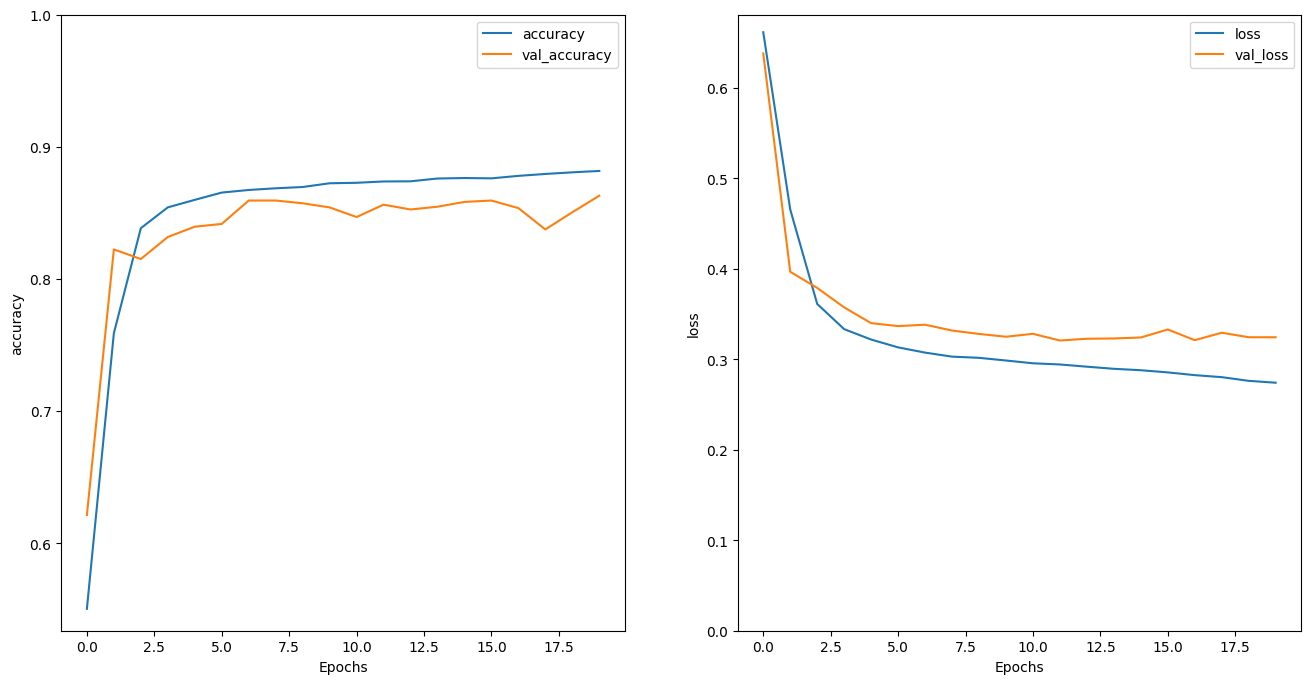

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers



In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 78s 154ms/step - loss: 0.6276 - accuracy: 0.5856 - val_loss: 0.4517 - val_accuracy: 0.7547
Epoch 2/20
391/391 [==============================] - 45s 115ms/step - loss: 0.3886 - accuracy: 0.8278 - val_loss: 0.3523 - val_accuracy: 0.8464
Epoch 3/20
391/391 [==============================] - 45s 114ms/step - loss: 0.3379 - accuracy: 0.8543 - val_loss: 0.3343 - val_accuracy: 0.8526
Epoch 4/20
391/391 [==============================] - 44s 112ms/step - loss: 0.3191 - accuracy: 0.8634 - val_loss: 0.3241 - val_accuracy: 0.8516
Epoch 5/20
391/391 [==============================] - 44s 113ms/step - loss: 0.3112 - accuracy: 0.8668 - val_loss: 0.3319 - val_accuracy: 0.8620
Epoch 6/20
391/391 [==============================] - 44s 112ms/step - loss: 0.3086 - accuracy: 0.8658 - val_loss: 0.3276 - val_accuracy: 0.8609
Epoch 7/20
391/391 [==============================] - 44s 112ms/step - loss: 0.3074 - accuracy: 0.8676 - val_loss: 0.3367 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 46ms/step - loss: 0.3282 - accuracy: 0.8449
Test Loss: 0.32819825410842896
Test Accuracy: 0.8449199795722961


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 26ms/step
[[-2.312]]


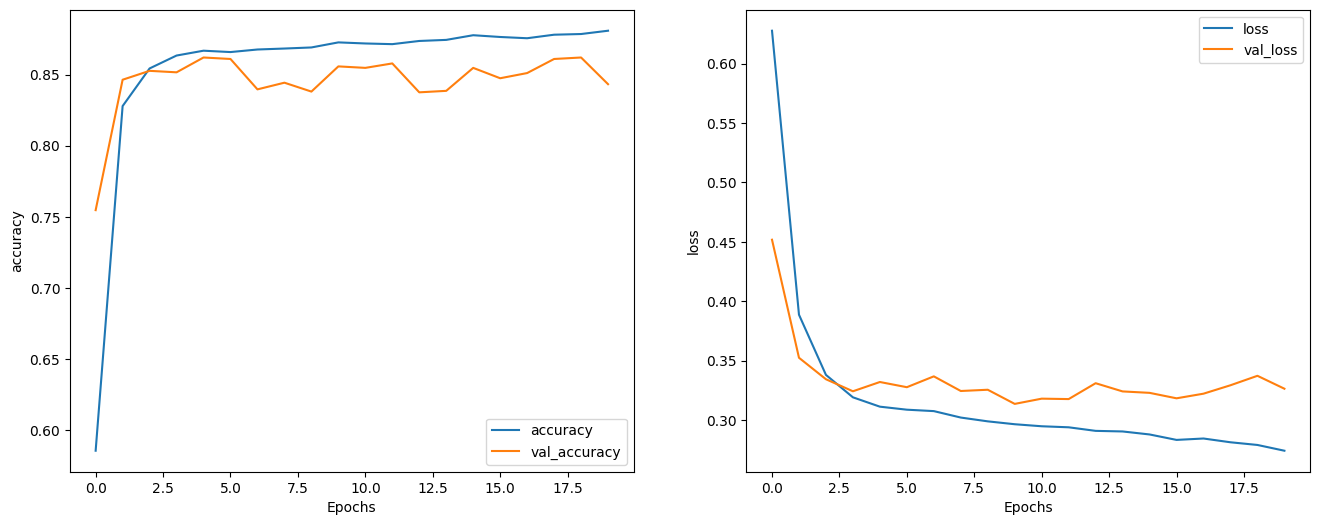

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# GRU

## GRU

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00188887]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 65s 130ms/step - loss: 0.6889 - accuracy: 0.5000 - val_loss: 0.6754 - val_accuracy: 0.4917
Epoch 2/20
391/391 [==============================] - 34s 87ms/step - loss: 0.4622 - accuracy: 0.7466 - val_loss: 0.3590 - val_accuracy: 0.8448
Epoch 3/20
391/391 [==============================] - 27s 70ms/step - loss: 0.3325 - accuracy: 0.8540 - val_loss: 0.3462 - val_accuracy: 0.8432
Epoch 4/20
391/391 [==============================] - 29s 75ms/step - loss: 0.3129 - accuracy: 0.8653 - val_loss: 0.3263 - val_accuracy: 0.8521
Epoch 5/20
391/391 [==============================] - 27s 69ms/step - loss: 0.3033 - accuracy: 0.8713 - val_loss: 0.3228 - val_accuracy: 0.8604
Epoch 6/20
391/391 [==============================] - 31s 79ms/step - loss: 0.2999 - accuracy: 0.8719 - val_loss: 0.3234 - val_accuracy: 0.8557
Epoch 7/20
391/391 [==============================] - 25s 63ms/step - loss: 0.2963 - accuracy: 0.8747 - val_loss: 0.3243 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 10s 27ms/step - loss: 0.3246 - accuracy: 0.8594
Test Loss: 0.3245905041694641
Test Accuracy: 0.8593999743461609


(0.0, 0.7097344264388085)

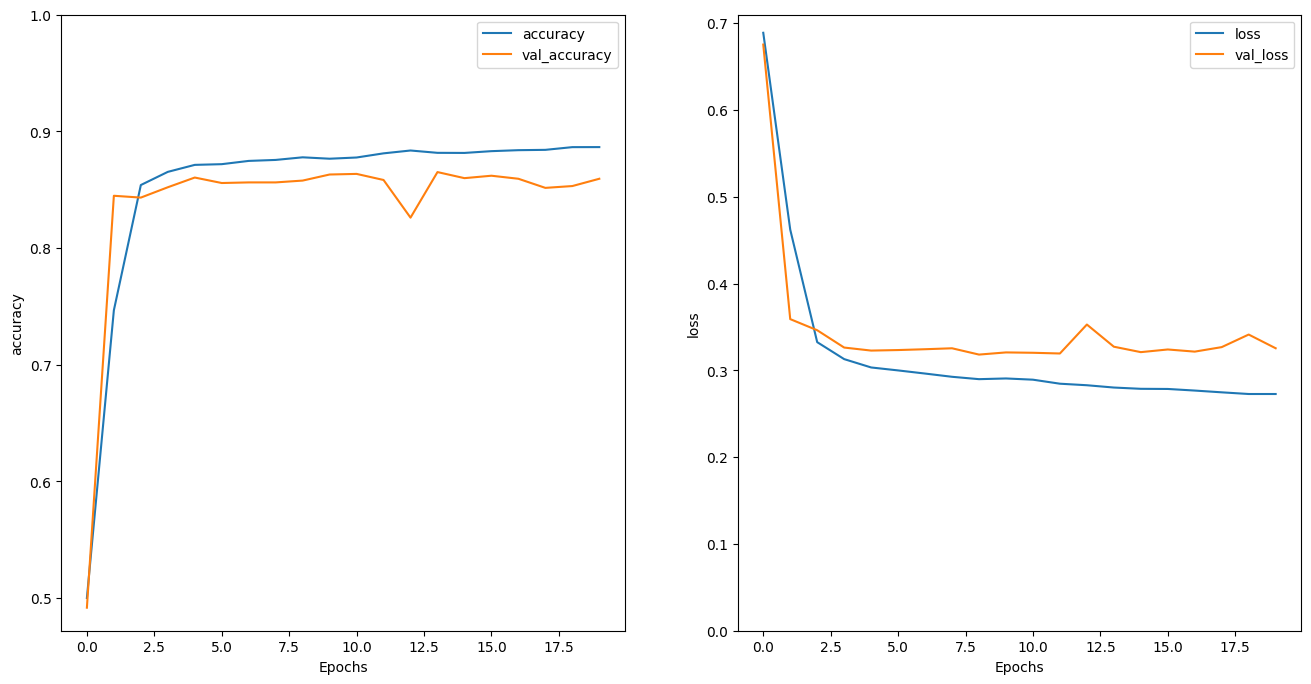

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[0.78783536]], dtype=float32)

## Stack two or more GRU layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 79s 159ms/step - loss: 0.6890 - accuracy: 0.5000 - val_loss: 0.6655 - val_accuracy: 0.4917
Epoch 2/20
391/391 [==============================] - 46s 118ms/step - loss: 0.4579 - accuracy: 0.7638 - val_loss: 0.3799 - val_accuracy: 0.8427
Epoch 3/20
391/391 [==============================] - 45s 116ms/step - loss: 0.3425 - accuracy: 0.8556 - val_loss: 0.3404 - val_accuracy: 0.8500
Epoch 4/20
391/391 [==============================] - 45s 114ms/step - loss: 0.3222 - accuracy: 0.8640 - val_loss: 0.3256 - val_accuracy: 0.8547
Epoch 5/20
391/391 [==============================] - 45s 114ms/step - loss: 0.3111 - accuracy: 0.8685 - val_loss: 0.3225 - val_accuracy: 0.8615
Epoch 6/20
391/391 [==============================] - 45s 114ms/step - loss: 0.3069 - accuracy: 0.8690 - val_loss: 0.3195 - val_accuracy: 0.8583
Epoch 7/20
391/391 [==============================] - 45s 115ms/step - loss: 0.3022 - accuracy: 0.8738 - val_loss: 0.3171 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 28s 71ms/step - loss: 0.3417 - accuracy: 0.8434
Test Loss: 0.3416501581668854
Test Accuracy: 0.8433600068092346


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-3.345282]]


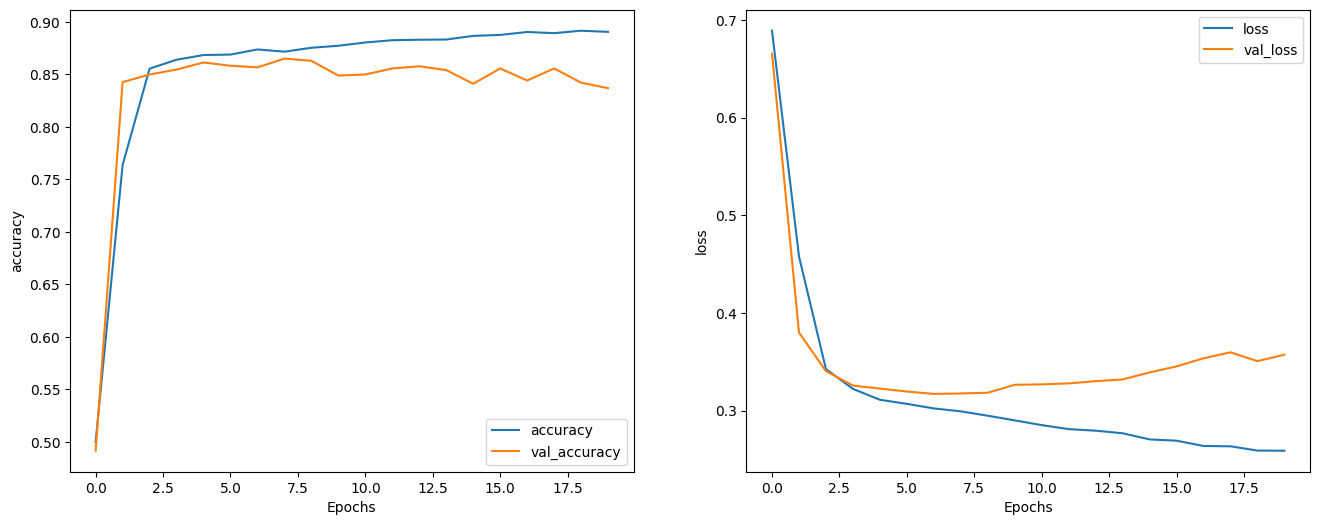

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# LSTM + GRU


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/20
391/391 [==============================] - 77s 155ms/step - loss: 0.6526 - accuracy: 0.5528 - val_loss: 0.5073 - val_accuracy: 0.7542
Epoch 2/20
391/391 [==============================] - 46s 117ms/step - loss: 0.4277 - accuracy: 0.8066 - val_loss: 0.3730 - val_accuracy: 0.8349
Epoch 3/20
391/391 [==============================] - 46s 117ms/step - loss: 0.3577 - accuracy: 0.8484 - val_loss: 0.3467 - val_accuracy: 0.8464
Epoch 4/20
391/391 [==============================] - 46s 118ms/step - loss: 0.3357 - accuracy: 0.8596 - val_loss: 0.3363 - val_accuracy: 0.8484
Epoch 5/20
391/391 [==============================] - 45s 114ms/step - loss: 0.3227 - accuracy: 0.8660 - val_loss: 0.3255 - val_accuracy: 0.8557
Epoch 6/20
391/391 [==============================] - 45s 115ms/step - loss: 0.3191 - accuracy: 0.8662 - val_loss: 0.3211 - val_accuracy: 0.8536
Epoch 7/20
391/391 [==============================] - 45s 115ms/step - loss: 0.3109 - accuracy: 0.8697 - val_loss: 0.3194 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3508 - accuracy: 0.8598
Test Loss: 0.3508366346359253
Test Accuracy: 0.8597999811172485


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-2.710727]]


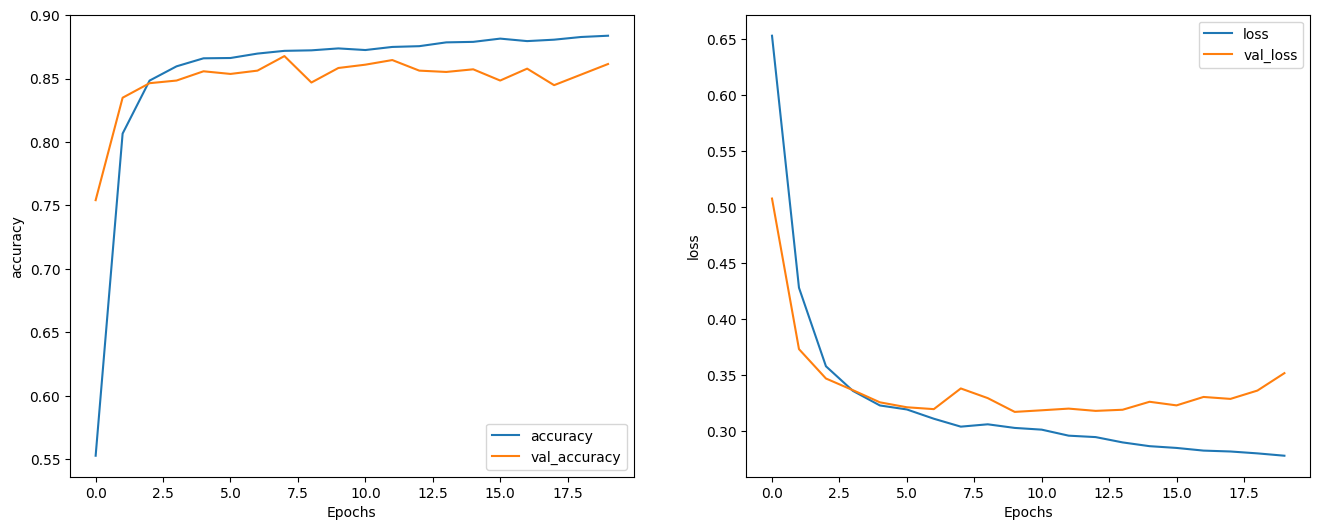

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# TOTAL



В ходе выполнения лабораторной работы по обучению сетей со слоями GRU (Gated Recurrent Unit) и LSTM (Long Short-Term Memory) были исследованы и сравнены два популярных подхода к моделированию последовательностей. Оба слоя GRU и LSTM представляют собой разновидности рекуррентных нейронных сетей, способных обрабатывать информацию с учетом долгосрочных зависимостей в последовательностях.

В результате эксперимента было установлено, что оба слоя GRU и LSTM способны эффективно обрабатывать и моделировать сложные последовательности. Однако было отмечено, что LSTM обычно имеет более высокую вычислительную сложность, чем GRU, за счет использования дополнительных вентилей и ячеек памяти.

Выводы из данной лабораторной работы могут быть полезны при выборе подходящего типа рекуррентного слоя в зависимости от конкретной задачи и требований к производительности. GRU может быть предпочтительным выбором, если требуется более легкая модель, а LSTM может быть полезным, если необходимо более точное моделирование долгосрочных зависимостей в данных.